In [1]:
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn import model_selection, metrics
from torch.utils.data import random_split

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torch.nn as nn

from datasets import load_dataset
from torch.utils.data.dataloader import default_collate

/home/suvivars/.conda/envs/271/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/home/suvivars/.conda/envs/271/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)
from torch.utils.data import Dataset, TensorDataset
import cv2
import tqdm
import json
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device="cpu"

In [5]:
np.random.seed(0)
torch.manual_seed(0)

In [6]:
normalize = Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

In [7]:
_train_transforms = Compose(
        [
            RandomResizedCrop((224,224)),
            RandomHorizontalFlip(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((224,224)),
            CenterCrop((224,224)),
            ToTensor(),
            normalize,
        ]
    )

In [8]:
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


In [11]:
X=[]
files=[]
for folder in tqdm.tqdm(os.listdir('UrbanSound8k/audio_mel/')):
    if '.' not in folder:
        for file in os.listdir('UrbanSound8k/audio_mel/'+folder):
            X.append(cv2.imread('UrbanSound8k/audio_mel/'+folder+'/'+file))
            files.append(file)
X=np.array(X).astype('float32')
X=np.array(X).reshape(-1,3,217,334)
X=torch.tensor(X)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:32<00:00,  2.71s/it]


In [12]:
len(files)

8732

In [13]:
X.shape

torch.Size([8732, 3, 217, 334])

In [14]:
with open('UrbanSound8k/metadata/metadata.jsonl', "r") as f:
    content = f.read()
label={}
decoder = json.JSONDecoder()

In [15]:
while content:
    value, new_start = decoder.raw_decode(content)
    content = content[new_start:].strip()
    label[value['file_name']]=value['classID']

In [16]:
len(label)

8732

In [17]:
Y = [label[i] for i in files]
Y = torch.tensor(Y)

In [18]:
Y.shape

torch.Size([8732])

In [19]:
full_set = CustomTensorDataset(tensors=(X, Y), transform=_train_transforms)

In [20]:
train_size = int(0.7 * len(full_set))
val_size = len(full_set) - train_size
train_set, validation_set = torch.utils.data.random_split(full_set, [train_size, val_size])

In [21]:
print(len(train_set))
print(len(validation_set))

6112
2620


In [22]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, collate_fn=lambda x: [y.to(device) for y in default_collate(x)] )
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=8, collate_fn=lambda x: [y.to(device) for y in default_collate(x)] )


In [23]:
class ViT(nn.Module):
    def __init__(self, input_shape, n_patches=4, hidden=8, num_heads=2, n_classes=10):
        # Super constructor
        super(ViT, self).__init__()

        # Input and patches sizes
        self.input_shape = input_shape
        self.n_patches = n_patches
        self.num_heads = num_heads
        assert input_shape[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert input_shape[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)
        self.hidden = hidden

        # 1) Linear mapper
        self.input = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input, self.hidden)

        # 2) Classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden))

        # 3) Positional embeddingin Forward function

        # 4a) Layer normalization 1
        self.ln1 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden))

        # 4b) Multi-head Self Attention (MSA) and classification token
        self.attn = Attention(self.hidden, num_heads)

        # 5a) Layer normalization 2
        self.ln2 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden))

        # 5b) Encoder MLP
        self.mlpenc = nn.Sequential(
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU())

        # 6) Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden, n_classes),
            nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, w, h = images.shape
        patches = images.reshape(n, self.n_patches ** 2, self.input)
        tokens = self.linear_mapper(patches)
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        # Adding positional embedding
        tokens += get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden).repeat(n, 1, 1)
        #tokens.to(device)
        # TRANSFORMER ENCODER
        output = tokens + self.attn(self.ln1(tokens))
        # Running Layer Normalization, MLP and residual connection
        output = output + self.mlpenc(self.ln2(output))
        # Getting the classification token
        output = output[:, 0]
        return self.mlp(output)

In [24]:
class Attention(nn.Module):
    def __init__(self, d, num_heads=2):
        super(Attention, self).__init__()
        self.d = d
        self.num_heads = num_heads
        d_head = int(d / num_heads)
        self.q_mappings = [nn.Linear(d_head, d_head).to(device) for _ in range(self.num_heads)]
        self.k_mappings = [nn.Linear(d_head, d_head).to(device) for _ in range(self.num_heads)]
        self.v_mappings = [nn.Linear(d_head, d_head).to(device) for _ in range(self.num_heads)]
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.num_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [25]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d).to(device)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [26]:
model = ViT((3, 224, 224), n_patches=4, hidden=20, num_heads=2, n_classes=10)
model.to(device)
N_EPOCHS = 71
LR = 0.005

In [27]:
model

ViT(
  (linear_mapper): Linear(in_features=9408, out_features=20, bias=True)
  (ln1): LayerNorm((17, 20), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (softmax): Softmax(dim=-1)
  )
  (ln2): LayerNorm((17, 20), eps=1e-05, elementwise_affine=True)
  (mlpenc): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [28]:
training_loss=[]
testing_loss=[]
testing_acc=[]
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_loss.append(train_loss)
    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
    
    # Test loop
    correct, total = 0, 0
    test_loss = 0.0
    for batch in validation_loader:
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)
        test_loss += loss

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        total += len(x)
    testing_loss.append(test_loss)
    testing_acc.append((correct / total) *100)
    print(f"Test loss: {test_loss/:.2f}")
    print(f"Test accuracy: {correct / total *100:.2f}%")

Epoch 1/71 loss: 180.51
Test loss: 63.55
Test accuracy: 28.44%
Epoch 2/71 loss: 176.76
Test loss: 63.00
Test accuracy: 31.12%
Epoch 3/71 loss: 175.39
Test loss: 62.99
Test accuracy: 31.33%
Epoch 4/71 loss: 174.06
Test loss: 62.09
Test accuracy: 37.00%
Epoch 5/71 loss: 172.92
Test loss: 61.70
Test accuracy: 39.78%
Epoch 6/71 loss: 172.42
Test loss: 61.30
Test accuracy: 41.43%
Epoch 7/71 loss: 171.68
Test loss: 61.54
Test accuracy: 40.55%
Epoch 8/71 loss: 171.55
Test loss: 61.30
Test accuracy: 41.69%
Epoch 9/71 loss: 171.28
Test loss: 61.58
Test accuracy: 39.21%
Epoch 10/71 loss: 170.75
Test loss: 60.86
Test accuracy: 43.85%
Epoch 11/71 loss: 169.35
Test loss: 60.35
Test accuracy: 46.01%
Epoch 12/71 loss: 168.35
Test loss: 60.80
Test accuracy: 42.87%
Epoch 13/71 loss: 168.10
Test loss: 60.31
Test accuracy: 46.58%
Epoch 14/71 loss: 167.66
Test loss: 60.21
Test accuracy: 47.15%
Epoch 15/71 loss: 167.38
Test loss: 60.48
Test accuracy: 45.34%
Epoch 16/71 loss: 167.92
Test loss: 60.24
Test ac

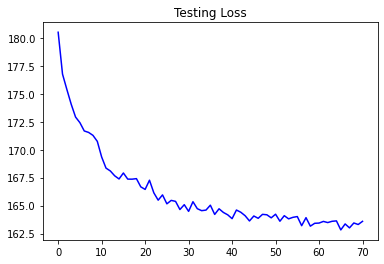

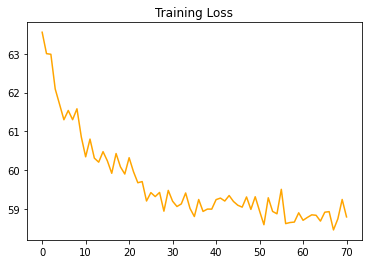

In [49]:
fig = plt.figure()
for tl in range(len(testing_loss)):
    testing_loss[tl] = float(testing_loss[tl])
plt.plot(training_loss,color = 'b')
plt.title("Testing Loss")
plt.show()
fig = plt.figure()
plt.title("Training Loss")
plt.plot(testing_loss,color='orange')
plt.show()

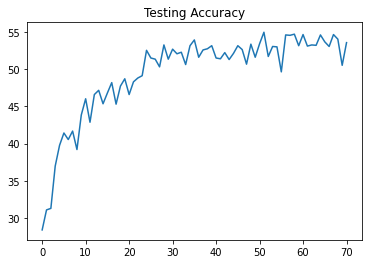

In [51]:
f = plt.figure()
plt.title("Testing Accuracy")
plt.plot(testing_acc)
plt.show()